# Turbofan Engine RUL Prediction - Baseline Model

**Dataset:** NASA C-MAPSS (FD001)  
**Model:** Linear Regression Baseline  
**Goal:** Predict Remaining Useful Life (RUL) of turbofan engines

---

## 1. Import Libraries

In [1]:
%pip install h5py numpy pandas matplotlib seaborn scikit-learn

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import os
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All libraries imported successfully!")

Note: you may need to restart the kernel to use updated packages.
✓ All libraries imported successfully!


## 2. Configuration

In [2]:
DATA_PATH = 'CMaps/'
FILENAME = 'N-CMAPSS_DS02-006.h5'
WINDOW_SIZE = 30
TEST_SIZE = 0.10
VAL_SIZE = 0.10
RANDOM_STATE = 42

print("Configuration:")
print(f"  Dataset: {FILENAME}")
print(f"  Window Size: {WINDOW_SIZE}")
print(f"  Train/Val/Test Split: {(1-TEST_SIZE-VAL_SIZE)*100:.0f}/{VAL_SIZE*100:.0f}/{TEST_SIZE*100:.0f}")
print(f"  Random State: {RANDOM_STATE}")

Configuration:
  Dataset: N-CMAPSS_DS02-006.h5
  Window Size: 30
  Train/Val/Test Split: 80/10/10
  Random State: 42


## 3. Data Loader

In [3]:
h5path = os.path.join(DATA_PATH, FILENAME)
hdf = h5py.File(h5path, 'r')

print("N-CMAPSS HDF5 File Structure:")
print("="*60)
for key in hdf.keys():
    print(f"{key:15s}   shape: {hdf[key].shape}   dtype: {hdf[key].dtype}")
print("="*60)

N-CMAPSS HDF5 File Structure:
A_dev             shape: (5263447, 4)   dtype: float64
A_test            shape: (1253743, 4)   dtype: float64
A_var             shape: (4,)   dtype: |S5
T_dev             shape: (5263447, 10)   dtype: float64
T_test            shape: (1253743, 10)   dtype: float64
T_var             shape: (10,)   dtype: |S12
W_dev             shape: (5263447, 4)   dtype: float64
W_test            shape: (1253743, 4)   dtype: float64
W_var             shape: (4,)   dtype: |S4
X_s_dev           shape: (5263447, 14)   dtype: float64
X_s_test          shape: (1253743, 14)   dtype: float64
X_s_var           shape: (14,)   dtype: |S4
X_v_dev           shape: (5263447, 14)   dtype: float64
X_v_test          shape: (1253743, 14)   dtype: float64
X_v_var           shape: (14,)   dtype: |S5
Y_dev             shape: (5263447, 1)   dtype: int64
Y_test            shape: (1253743, 1)   dtype: int64


## 4. Helper Function and Load Variable Names

In [4]:
def decode(byte_array):
    return [x.decode('utf-8') for x in byte_array]

A_var = decode(hdf["A_var"])
W_var = decode(hdf["W_var"])
Xs_var = decode(hdf["X_s_var"])
Xv_var = decode(hdf["X_v_var"])

if "T_var" in hdf:
    T_var = decode(hdf["T_var"])
    print("T columns:", T_var)

print("A columns (Auxiliary):", A_var)
print("W columns (Operating):", W_var)
print("Xs columns (Physical Sensors):", Xs_var)
print("Xv columns (Virtual Sensors - EXCLUDED):", Xv_var[:5], "...")

T columns: ['fan_eff_mod', 'fan_flow_mod', 'LPC_eff_mod', 'LPC_flow_mod', 'HPC_eff_mod', 'HPC_flow_mod', 'HPT_eff_mod', 'HPT_flow_mod', 'LPT_eff_mod', 'LPT_flow_mod']
A columns (Auxiliary): ['unit', 'cycle', 'Fc', 'hs']
W columns (Operating): ['alt', 'Mach', 'TRA', 'T2']
Xs columns (Physical Sensors): ['T24', 'T30', 'T48', 'T50', 'P15', 'P2', 'P21', 'P24', 'Ps30', 'P40', 'P50', 'Nf', 'Nc', 'Wf']
Xv columns (Virtual Sensors - EXCLUDED): ['T40', 'P30', 'P45', 'W21', 'W22'] ...


## 5. Load Training Data

In [5]:
A_dev = hdf["A_dev"][:]
W_dev = hdf["W_dev"][:]
Xs_dev = hdf["X_s_dev"][:]
Y_dev = hdf["Y_dev"][:]

print("Data loaded:")
print(f"  A_dev (Auxiliary): {A_dev.shape}")
print(f"  W_dev (Operating): {W_dev.shape}")
print(f"  Xs_dev (Sensors): {Xs_dev.shape}")
print(f"  Y_dev (RUL): {Y_dev.shape}")

df_A = pd.DataFrame(A_dev, columns=A_var)
df_W = pd.DataFrame(W_dev, columns=W_var)
df_Xs = pd.DataFrame(Xs_dev, columns=Xs_var)

df_dev = pd.concat([df_A, df_W, df_Xs], axis=1)
df_dev['RUL'] = Y_dev[:, 0]

print(f"\n✓ Combined dataframe shape: {df_dev.shape}")
print(f"✓ Columns: {list(df_dev.columns)}")
df_dev.head()

Data loaded:
  A_dev (Auxiliary): (5263447, 4)
  W_dev (Operating): (5263447, 4)
  Xs_dev (Sensors): (5263447, 14)
  Y_dev (RUL): (5263447, 1)

✓ Combined dataframe shape: (5263447, 23)
✓ Columns: ['unit', 'cycle', 'Fc', 'hs', 'alt', 'Mach', 'TRA', 'T2', 'T24', 'T30', 'T48', 'T50', 'P15', 'P2', 'P21', 'P24', 'Ps30', 'P40', 'P50', 'Nf', 'Nc', 'Wf', 'RUL']


,unit,cycle,Fc,hs,alt,Mach,TRA,T2,T24,T30,...,P2,P21,P24,Ps30,P40,P50,Nf,Nc,Wf,RUL
0,2.0,1.0,3.0,1.0,10005.0,0.448497,76.903748,502.420918,600.148034,1438.498187,...,11.577097,16.046971,20.126624,331.293679,336.631827,12.629361,2160.926416,8591.373490,3.855337,74
1,2.0,1.0,3.0,1.0,10013.0,0.447741,76.903748,502.326114,600.055894,1438.350208,...,11.568235,16.036017,20.113218,331.109867,336.446748,12.623033,2160.909333,8590.972866,3.852319,74
2,2.0,1.0,3.0,1.0,10017.0,0.448938,77.079529,502.416067,600.210756,1439.109101,...,11.574866,16.048474,20.130956,331.753181,337.082502,12.637951,2161.819062,8593.031745,3.866201,74
3,2.0,1.0,3.0,1.0,10024.0,0.449883,77.079529,502.469893,600.369717,1439.240230,...,11.578198,16.057218,20.146716,331.819136,337.162828,12.631509,2162.768666,8593.781545,3.863328,74
4,2.0,1.0,3.0,1.0,10031.0,0.449379,77.079529,502.401271,600.298227,1439.064004,...,11.571593,16.048236,20.135888,331.626003,336.966936,12.624872,2162.619544,8593.220200,3.860818,74


## 6. Basic Dataset Statistics

In [6]:
print("Dataset Statistics:")
print("="*60)
print(f"Number of samples: {len(df_dev):,}")
print(f"Number of engines: {df_dev['unit'].nunique()}")
print(f"Number of cycles: {df_dev['cycle'].nunique()}")
print(f"\nRUL range: [{df_dev['RUL'].min():.0f}, {df_dev['RUL'].max():.0f}] cycles")
print(f"RUL mean: {df_dev['RUL'].mean():.1f} cycles")

print("\nCycles per engine:")
print(df_dev.groupby('unit')['cycle'].max())

print("\nSamples per engine:")
print(df_dev.groupby('unit').size())
print("="*60)

Dataset Statistics:
Number of samples: 5,263,447
Number of engines: 6
Number of cycles: 89

RUL range: [0, 88] cycles
RUL mean: 37.3 cycles

Cycles per engine:
unit
2.0     75.0
5.0     89.0
10.0    82.0
16.0    63.0
18.0    71.0
20.0    66.0
Name: cycle, dtype: float64

Samples per engine:
unit
2.0      853142
5.0     1033420
10.0     952711
16.0     765295
18.0     890719
20.0     768160
dtype: int64


## 7. Define Feature Columns

In [7]:
scenario_cols = ['alt', 'Mach', 'TRA', 'T2']

sensor_cols = [
    'Wf',   # Fuel flow
    'Nf',   # Physical fan speed
    'Nc',   # Physical core speed
    'T24',  # Total temp at LPC outlet
    'T30',  # Total temp at HPC outlet
    'T48',  # Total temp at HPT outlet
    'T50',  # Total temp at LPT outlet
    'P15',  # Total pressure in bypass-duct
    'P2',   # Total pressure at fan inlet
    'P21',  # Total pressure at fan outlet
    'Ps30', # Static pressure at HPC outlet
    'P40',  # Total pressure at burner outlet
    'P50'   # Total pressure at LPT outlet
]

candidate_cols = scenario_cols + sensor_cols

candidate_cols = [col for col in candidate_cols if col in df_dev.columns]

print("Feature columns (17 physical variables per document):")
print(f"  Scenario descriptors: {scenario_cols}")
print(f"  Physical sensors: {sensor_cols}")
print(f"  Total features: {len(candidate_cols)}")
print(f"\n✓ All columns verified in dataset")

Feature columns (17 physical variables per document):
  Scenario descriptors: ['alt', 'Mach', 'TRA', 'T2']
  Physical sensors: ['Wf', 'Nf', 'Nc', 'T24', 'T30', 'T48', 'T50', 'P15', 'P2', 'P21', 'Ps30', 'P40', 'P50']
  Total features: 17

✓ All columns verified in dataset


## 8. Feature Selection

Feature Selection: Correlation with RUL

Correlation with RUL:
T50    -0.126475
T48    -0.074675
Nc      0.024205
Wf     -0.020594
Mach    0.015666
T24    -0.011008
alt     0.010162
T30     0.010153
P50    -0.008643
TRA     0.008057
P2     -0.007272
Nf      0.007115
T2     -0.006856
P21    -0.006542
P15    -0.006542
P40     0.002407
Ps30    0.001256
Name: RUL, dtype: float64

Selected Features (top 10 by correlation):
 1. T50        Correlation: -0.1265
 2. T48        Correlation: -0.0747
 3. Nc         Correlation:  0.0242
 4. Wf         Correlation: -0.0206
 5. Mach       Correlation:  0.0157
 6. T24        Correlation: -0.0110
 7. alt        Correlation:  0.0102
 8. T30        Correlation:  0.0102
 9. P50        Correlation: -0.0086
10. TRA        Correlation:  0.0081

Total selected features: 10


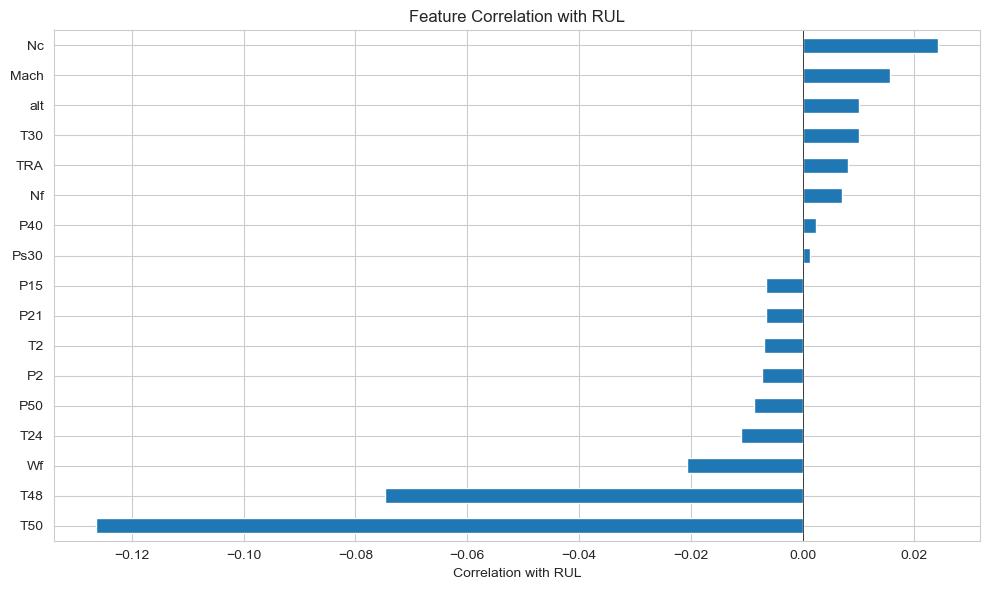

In [8]:
print("Feature Selection: Correlation with RUL")
print("="*60)

corr_w_rul = df_dev[candidate_cols + ["RUL"]].corr()["RUL"].drop("RUL")
corr_w_rul = corr_w_rul.reindex(corr_w_rul.abs().sort_values(ascending=False).index)

print("\nCorrelation with RUL:")
print(corr_w_rul)

k = 10
selected_features = corr_w_rul.abs().head(k).index.tolist()

print(f"\n{'='*60}")
print(f"Selected Features (top {k} by correlation):")
print(f"{'='*60}")
for i, feat in enumerate(selected_features, 1):
    corr_val = corr_w_rul[feat]
    print(f"{i:2d}. {feat:8s}   Correlation: {corr_val:7.4f}")

print(f"\nTotal selected features: {len(selected_features)}")

plt.figure(figsize=(10, 6))
corr_w_rul.sort_values(ascending=True).plot(kind='barh')
plt.xlabel('Correlation with RUL')
plt.title('Feature Correlation with RUL')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

## 9. Create Rolling Window Features

In [9]:
def create_window_features(df, feature_cols, window_size=30):
    print(f"Creating rolling window features (window={window_size})...")
    
    feature_list = []
    
    for unit_id in df['unit'].unique():
        unit_data = df[df['unit'] == unit_id].sort_values('cycle').copy()
        
        for col in feature_cols:
            if col in unit_data.columns:
                # Rolling statistics
                unit_data[f'{col}_mean'] = unit_data[col].rolling(
                    window=window_size, min_periods=1
                ).mean()
                
                unit_data[f'{col}_std'] = unit_data[col].rolling(
                    window=window_size, min_periods=1
                ).std().fillna(0)
                
                unit_data[f'{col}_min'] = unit_data[col].rolling(
                    window=window_size, min_periods=1
                ).min()
                
                unit_data[f'{col}_max'] = unit_data[col].rolling(
                    window=window_size, min_periods=1
                ).max()
                
                # Calculate slope (linear trend)
                def calc_slope(series):
                    if len(series) < 2:
                        return 0
                    x = np.arange(len(series))
                    y = series.values
                    slope = np.polyfit(x, y, 1)[0]
                    return slope
                
                unit_data[f'{col}_slope'] = unit_data[col].rolling(
                    window=window_size, min_periods=2
                ).apply(calc_slope, raw=False).fillna(0)
        
        feature_list.append(unit_data)
        
    result_df = pd.concat(feature_list, ignore_index=True)
    print(f"✓ Window features created. New shape: {result_df.shape}")
    
    return result_df

df_features = create_window_features(df_dev, selected_features, WINDOW_SIZE)

window_feature_cols = [col for col in df_features.columns 
                       if any(stat in col for stat in ['_mean', '_std', '_min', '_max', '_slope'])]

print(f"\nTotal window features created: {len(window_feature_cols)}")
print(f"Features per sensor: 5 (mean, std, min, max, slope)")
print(f"Expected: {len(selected_features)} × 5 = {len(selected_features)*5}")

Creating rolling window features (window=30)...
✓ Window features created. New shape: (5263447, 73)

Total window features created: 50
Features per sensor: 5 (mean, std, min, max, slope)
Expected: 10 × 5 = 50


## 10. Prepare Features and Split Data

In [10]:
X = df_features[window_feature_cols].values
y = df_features['RUL'].values

print(f"Feature matrix: {X.shape}")
print(f"Target vector: {y.shape}")

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

val_size_adjusted = VAL_SIZE / (1 - TEST_SIZE)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=val_size_adjusted, random_state=RANDOM_STATE
)

print(f"\nData split:")
print(f"  Training:   {X_train.shape[0]:6,} samples ({X_train.shape[0]/len(X)*100:5.1f}%)")
print(f"  Validation: {X_val.shape[0]:6,} samples ({X_val.shape[0]/len(X)*100:5.1f}%)")
print(f"  Test:       {X_test.shape[0]:6,} samples ({X_test.shape[0]/len(X)*100:5.1f}%)")

Feature matrix: (5263447, 50)
Target vector: (5263447,)

Data split:
  Training:   4,210,757 samples ( 80.0%)
  Validation: 526,345 samples ( 10.0%)
  Test:       526,345 samples ( 10.0%)


## 11. Train Baseline Model

In [11]:
print("Training Linear Regression Baseline Model...")
print("="*60)

model = LinearRegression()
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

model.fit(X_train_scaled, y_train)

print("✓ Model training complete!")

y_train_pred = model.predict(X_train_scaled)
y_val_pred = model.predict(X_val_scaled)
y_test_pred = model.predict(X_test_scaled)

print("✓ Predictions complete!")

Training Linear Regression Baseline Model...
✓ Model training complete!
✓ Predictions complete!


## 12. Evaluation Metrics

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def calculate_nasa_score(y_true, y_pred):
    """
    NASA Scoring Function (asymmetric)
    From document equation (2):
    - Penalizes late predictions less (a = -1/13)
    - Penalizes early predictions more (a = 1/10)
    """
    errors = y_true - y_pred
    score = 0
    
    for error in errors:
        if error < 0:
            score += np.exp(-error / 13) - 1
        else:
            score += np.exp(error / 10) - 1
    
    return score

def evaluate_all(y_true, y_pred, dataset_name=""):
    mse = mean_squared_error(y_true, y_pred)
    rmse = calculate_rmse(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    nasa_score = calculate_nasa_score(y_true, y_pred)
    
    print(f"\n{'='*60}")
    print(f"{dataset_name} Evaluation Metrics")
    print(f"{'='*60}")
    print(f"MSE:          {mse:10.2f}")
    print(f"RMSE:         {rmse:10.2f}")
    print(f"MAE:          {mae:10.2f}")
    print(f"NASA Score:   {nasa_score:10.2f}")
    print(f"{'='*60}")
    
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'NASA_Score': nasa_score}

train_metrics = evaluate_all(y_train, y_train_pred, "Training Set")
val_metrics = evaluate_all(y_val, y_val_pred, "Validation Set")
test_metrics = evaluate_all(y_test, y_test_pred, "Test Set")


Training Set Evaluation Metrics
MSE:              139.73
RMSE:              11.82
MAE:                9.86
NASA Score:   9201929.28

Validation Set Evaluation Metrics
MSE:              139.51
RMSE:              11.81
MAE:                9.85
NASA Score:   1146810.21

Test Set Evaluation Metrics
MSE:              139.68
RMSE:              11.82
MAE:                9.86
NASA Score:   1149589.51


## 13. Visualizations

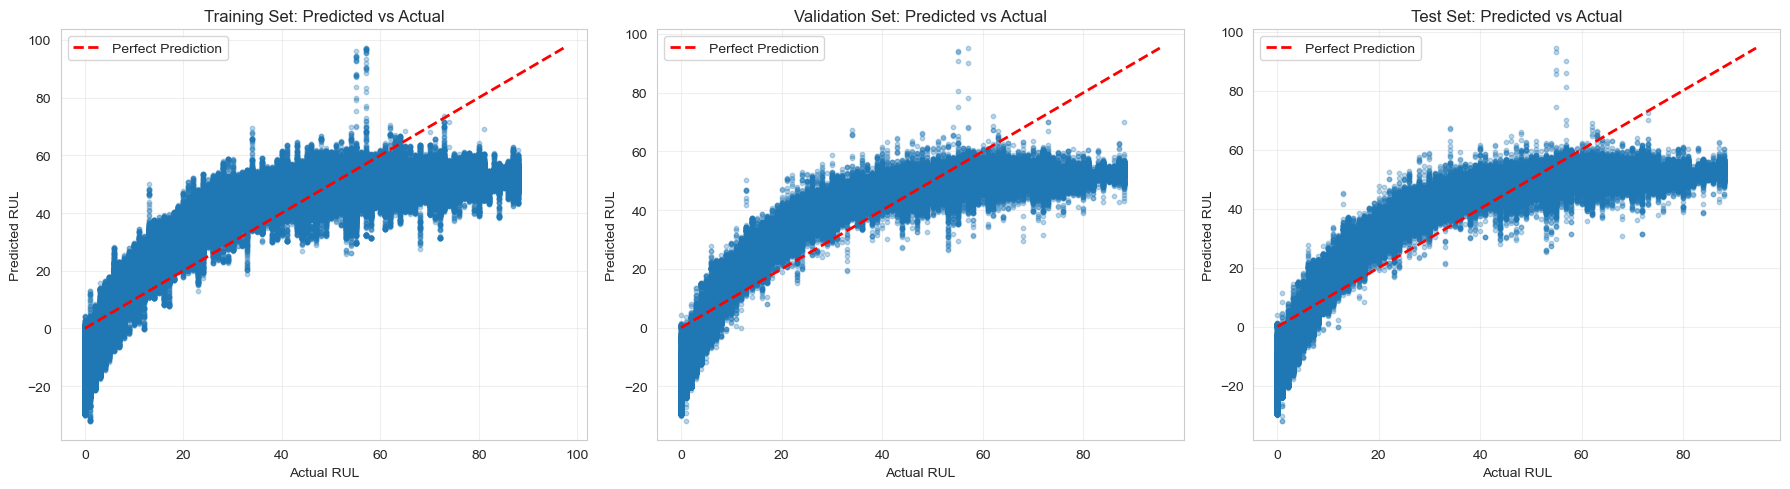

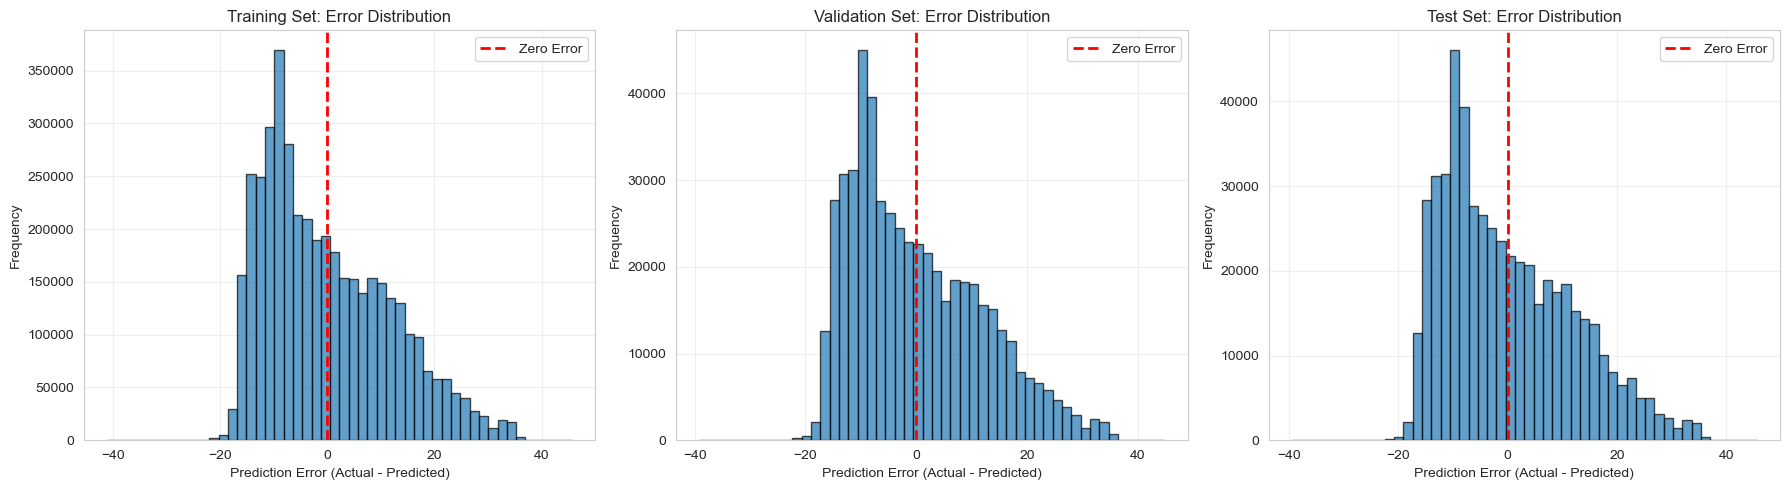

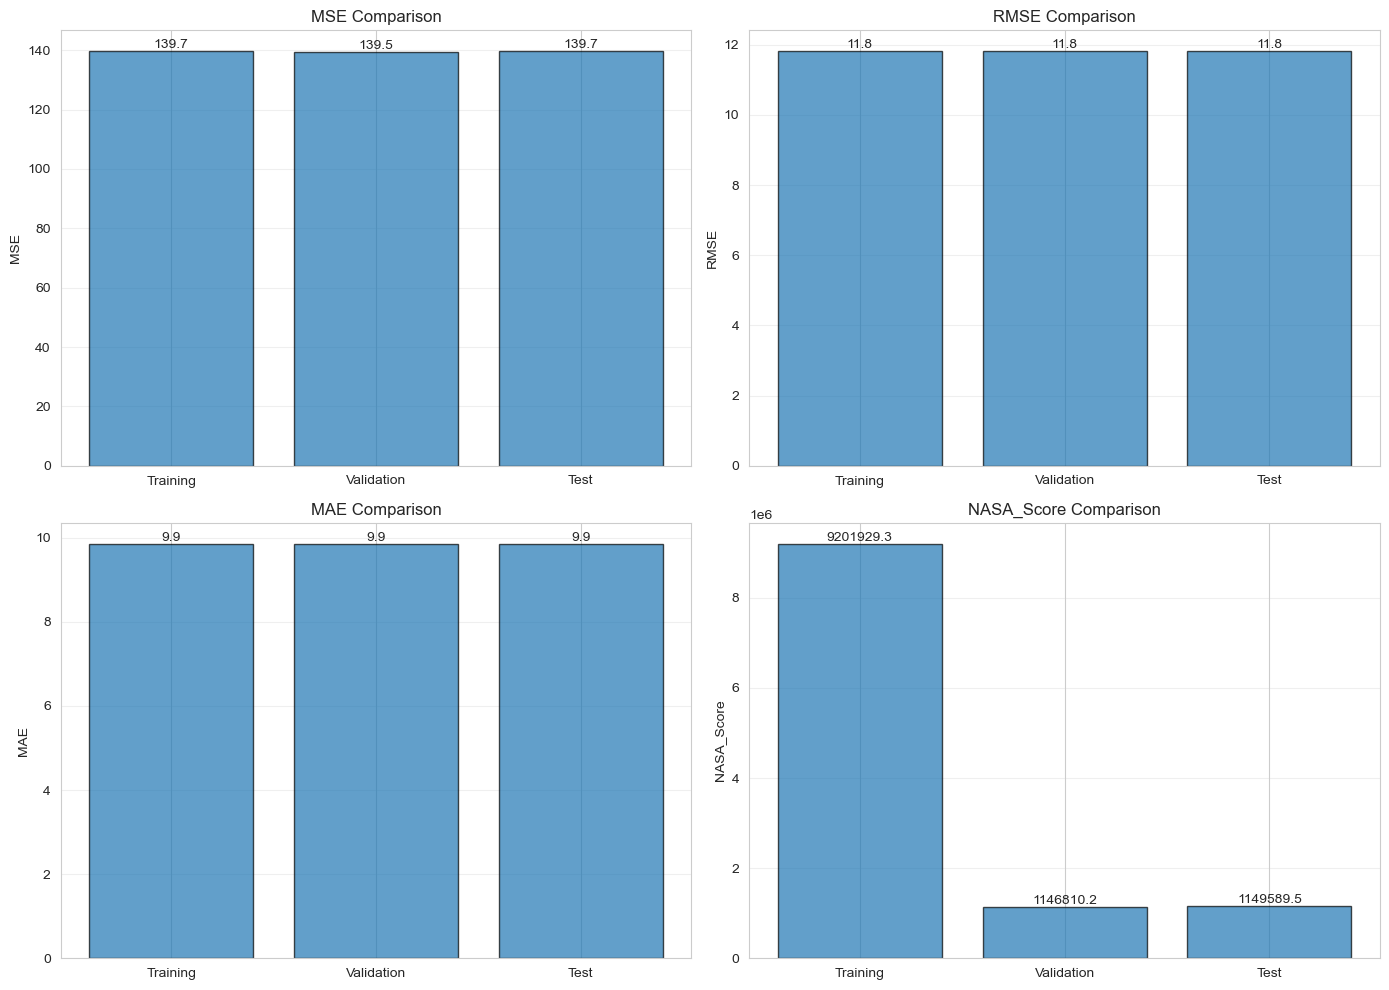

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

datasets = [
    (y_train, y_train_pred, "Training"),
    (y_val, y_val_pred, "Validation"),
    (y_test, y_test_pred, "Test")
]

for ax, (y_true, y_pred, name) in zip(axes, datasets):
    ax.scatter(y_true, y_pred, alpha=0.3, s=10)
    max_val = max(y_true.max(), y_pred.max())
    ax.plot([0, max_val], [0, max_val], 'r--', lw=2, label='Perfect Prediction')
    ax.set_xlabel('Actual RUL')
    ax.set_ylabel('Predicted RUL')
    ax.set_title(f'{name} Set: Predicted vs Actual')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (y_true, y_pred, name) in zip(axes, datasets):
    errors = y_true - y_pred
    ax.hist(errors, bins=50, edgecolor='black', alpha=0.7)
    ax.axvline(x=0, color='r', linestyle='--', lw=2, label='Zero Error')
    ax.set_xlabel('Prediction Error (Actual - Predicted)')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{name} Set: Error Distribution')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

metrics_df = pd.DataFrame({
    'Training': train_metrics,
    'Validation': val_metrics,
    'Test': test_metrics
})

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = ['MSE', 'RMSE', 'MAE', 'NASA_Score']

for ax, metric in zip(axes.flat, metrics):
    values = metrics_df.loc[metric]
    bars = ax.bar(values.index, values.values, alpha=0.7, edgecolor='black')
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} Comparison')
    ax.grid(True, alpha=0.3, axis='y')

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 14. Save Results

In [14]:
os.makedirs('results', exist_ok=True)

with open('results/baseline_results.txt', 'w') as f:
    f.write("="*60 + "\n")
    f.write("N-CMAPSS Baseline Model Results\n")
    f.write("="*60 + "\n\n")
    
    f.write(f"Dataset: {FILENAME}\n")
    f.write(f"Window Size: {WINDOW_SIZE}\n")
    f.write(f"Selected Features: {len(selected_features)}\n")
    f.write(f"Window Features: {len(window_feature_cols)}\n\n")
    
    for name, metrics in [('Training', train_metrics), 
                          ('Validation', val_metrics), 
                          ('Test', test_metrics)]:
        f.write(f"{name} Set:\n")
        for metric, value in metrics.items():
            f.write(f"  {metric}: {value:.2f}\n")
        f.write("\n")

print("\n" + "="*60)
print("✓ Baseline model training complete!")
print(f"✓ Results saved to 'results/baseline_results.txt'")
print("="*60)


✓ Baseline model training complete!
✓ Results saved to 'results/baseline_results.txt'


## 15. Regularization Additions

In [15]:
from sklearn.linear_model import Ridge
import time

print("="*60)
print("Testing Ridge Regression (L2 Regularization)")
print("="*60)

alphas = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

results_dict = {
    'Model': [],
    'Alpha': [],
    'Train_RMSE': [],
    'Val_RMSE': [],
    'Test_RMSE': [],
    'Train_MAE': [],
    'Val_MAE': [],
    'Test_MAE': [],
    'Train_NASA': [],
    'Val_NASA': [],
    'Test_NASA': [],
    'Training_Time': []
}

print("\n0. Baseline (No Regularization)")
print("-"*60)
results_dict['Model'].append('Baseline')
results_dict['Alpha'].append(0)
results_dict['Train_RMSE'].append(train_metrics['RMSE'])
results_dict['Val_RMSE'].append(val_metrics['RMSE'])
results_dict['Test_RMSE'].append(test_metrics['RMSE'])
results_dict['Train_MAE'].append(train_metrics['MAE'])
results_dict['Val_MAE'].append(val_metrics['MAE'])
results_dict['Test_MAE'].append(test_metrics['MAE'])
results_dict['Train_NASA'].append(train_metrics['NASA_Score'])
results_dict['Val_NASA'].append(val_metrics['NASA_Score'])
results_dict['Test_NASA'].append(test_metrics['NASA_Score'])
results_dict['Training_Time'].append(0)

print(f"  Val RMSE: {val_metrics['RMSE']:.2f}")
print(f"  Val NASA: {val_metrics['NASA_Score']:.2f}")

print("\n1. Testing Ridge Regression (L2 Regularization)...")
print("-"*60)

for alpha in alphas:
    print(f"\nAlpha = {alpha}")
    
    start_time = time.time()
    
    ridge_model = Ridge(alpha=alpha, random_state=RANDOM_STATE)
    ridge_model.fit(X_train_scaled, y_train)
    
    training_time = time.time() - start_time
    
    y_train_pred_ridge = ridge_model.predict(X_train_scaled)
    y_val_pred_ridge = ridge_model.predict(X_val_scaled)
    y_test_pred_ridge = ridge_model.predict(X_test_scaled)
    
    train_rmse = calculate_rmse(y_train, y_train_pred_ridge)
    val_rmse = calculate_rmse(y_val, y_val_pred_ridge)
    test_rmse = calculate_rmse(y_test, y_test_pred_ridge)
    
    train_mae = mean_absolute_error(y_train, y_train_pred_ridge)
    val_mae = mean_absolute_error(y_val, y_val_pred_ridge)
    test_mae = mean_absolute_error(y_test, y_test_pred_ridge)
    
    train_nasa = calculate_nasa_score(y_train, y_train_pred_ridge)
    val_nasa = calculate_nasa_score(y_val, y_val_pred_ridge)
    test_nasa = calculate_nasa_score(y_test, y_test_pred_ridge)
    
    results_dict['Model'].append('Ridge')
    results_dict['Alpha'].append(alpha)
    results_dict['Train_RMSE'].append(train_rmse)
    results_dict['Val_RMSE'].append(val_rmse)
    results_dict['Test_RMSE'].append(test_rmse)
    results_dict['Train_MAE'].append(train_mae)
    results_dict['Val_MAE'].append(val_mae)
    results_dict['Test_MAE'].append(test_mae)
    results_dict['Train_NASA'].append(train_nasa)
    results_dict['Val_NASA'].append(val_nasa)
    results_dict['Test_NASA'].append(test_nasa)
    results_dict['Training_Time'].append(training_time)
    
    print(f"  Val RMSE: {val_rmse:.2f}, Val NASA: {val_nasa:.2f}, Time: {training_time:.2f}s")

print("\n" + "="*60)
print("Ridge regularization experiments complete!")
print("="*60)

Testing Ridge Regression (L2 Regularization)

0. Baseline (No Regularization)
------------------------------------------------------------
  Val RMSE: 11.81
  Val NASA: 1146810.21

1. Testing Ridge Regression (L2 Regularization)...
------------------------------------------------------------

Alpha = 0.001
  Val RMSE: 11.81, Val NASA: 1146810.22, Time: 2.06s

Alpha = 0.01
  Val RMSE: 11.81, Val NASA: 1146810.36, Time: 1.65s

Alpha = 0.1
  Val RMSE: 11.81, Val NASA: 1146811.74, Time: 1.78s

Alpha = 1.0
  Val RMSE: 11.81, Val NASA: 1146829.21, Time: 2.04s

Alpha = 10.0
  Val RMSE: 11.81, Val NASA: 1147179.24, Time: 1.89s

Alpha = 100.0
  Val RMSE: 11.83, Val NASA: 1150126.49, Time: 2.01s

Alpha = 1000.0
  Val RMSE: 11.90, Val NASA: 1167486.83, Time: 2.12s

Ridge regularization experiments complete!


## 16. Visualization of Regularization


Ridge Regularization Results:
   Model    Alpha  Train_RMSE  Val_RMSE  Test_RMSE  Train_MAE  Val_MAE  Test_MAE   Train_NASA     Val_NASA    Test_NASA  Training_Time
Baseline    0.000   11.820745 11.811242  11.818655   9.860341 9.852740  9.858246 9.201929e+06 1.146810e+06 1.149590e+06       0.000000
   Ridge    0.001   11.820745 11.811242  11.818655   9.860341 9.852740  9.858246 9.201929e+06 1.146810e+06 1.149590e+06       2.061390
   Ridge    0.010   11.820745 11.811242  11.818655   9.860341 9.852740  9.858246 9.201929e+06 1.146810e+06 1.149590e+06       1.651548
   Ridge    0.100   11.820745 11.811243  11.818652   9.860340 9.852741  9.858243 9.201932e+06 1.146812e+06 1.149590e+06       1.775162
   Ridge    1.000   11.820768 11.811270  11.818646   9.860344 9.852763  9.858232 9.201987e+06 1.146829e+06 1.149599e+06       2.044943
   Ridge   10.000   11.822032 11.812584  11.819683   9.861253 9.853761  9.859008 9.204182e+06 1.147179e+06 1.149892e+06       1.894332
   Ridge  100.000   11.8

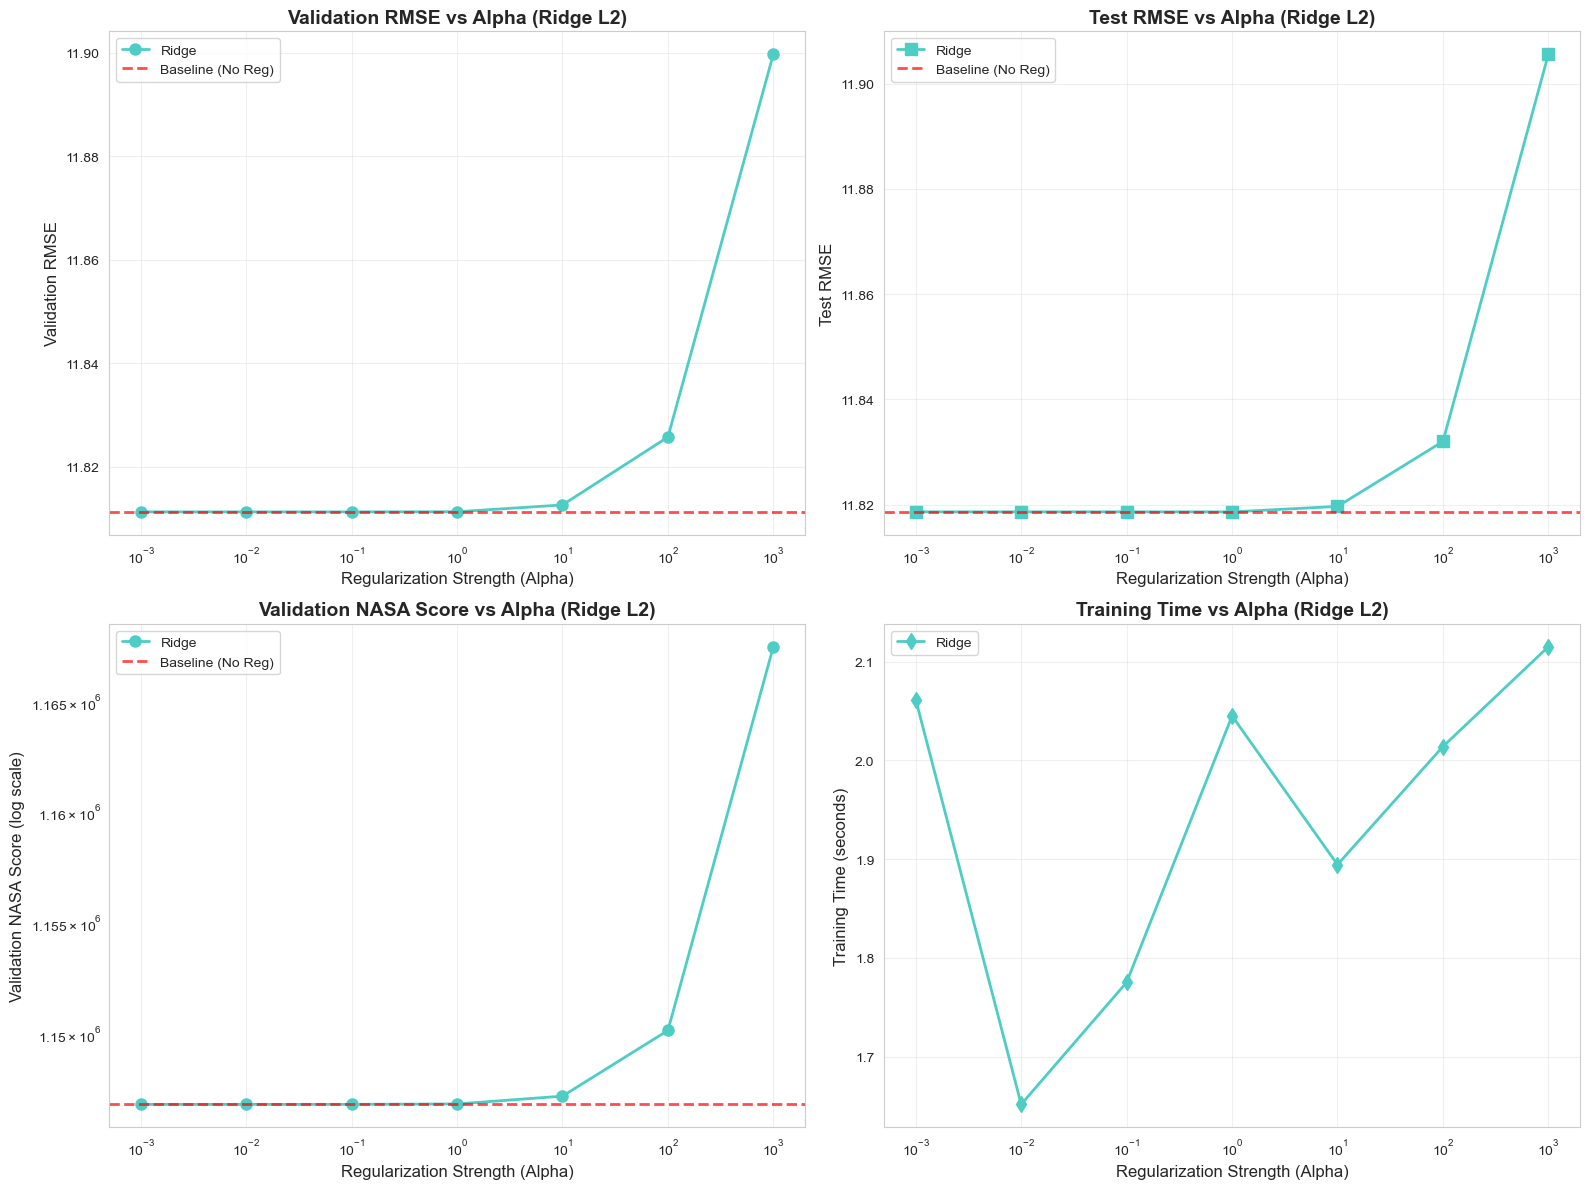

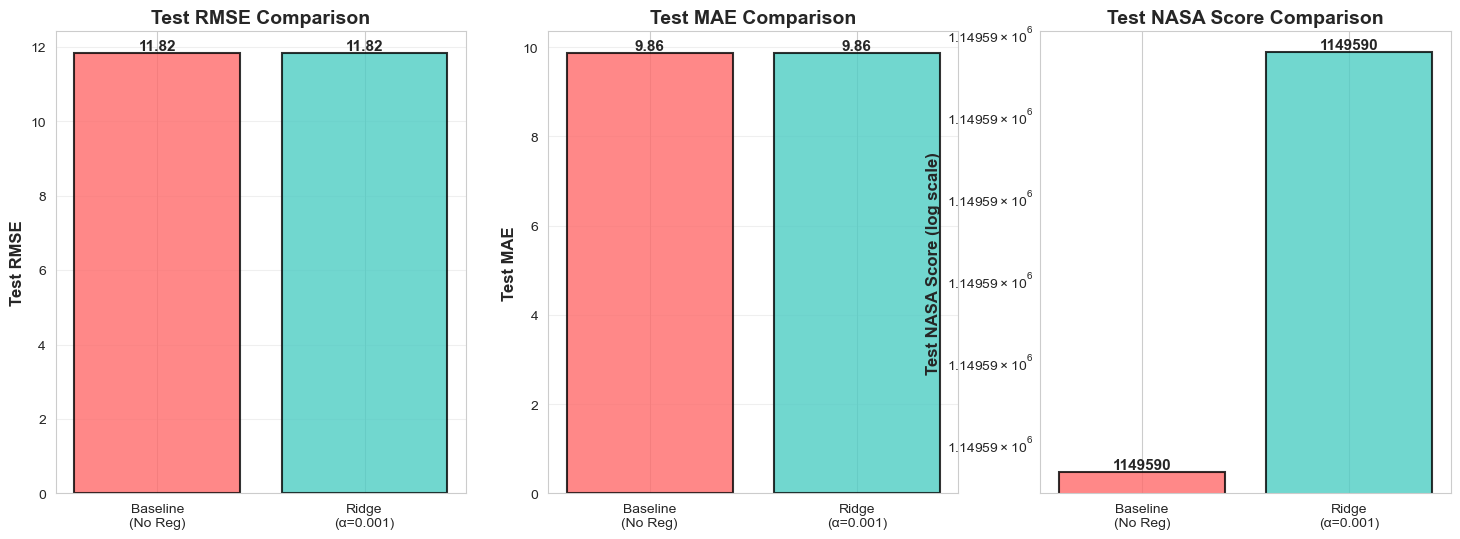

In [16]:
results_df = pd.DataFrame(results_dict)

print("\nRidge Regularization Results:")
print("="*100)
print(results_df.to_string(index=False))
print("="*100)

print("\n📌 Best Ridge Models by Validation RMSE:")
print("-"*60)
best_5 = results_df.nsmallest(5, 'Val_RMSE')[['Model', 'Alpha', 'Val_RMSE', 'Test_RMSE', 'Val_NASA', 'Test_NASA']]
print(best_5.to_string(index=False))

print("\n📌 Best Ridge Models by Validation NASA Score:")
print("-"*60)
best_5_nasa = results_df.nsmallest(5, 'Val_NASA')[['Model', 'Alpha', 'Val_RMSE', 'Test_RMSE', 'Val_NASA', 'Test_NASA']]
print(best_5_nasa.to_string(index=False))

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

ax = axes[0, 0]
ridge_data = results_df[results_df['Model'] == 'Ridge']
baseline_rmse = results_df[results_df['Model'] == 'Baseline']['Val_RMSE'].values[0]

ax.semilogx(ridge_data['Alpha'], ridge_data['Val_RMSE'], 
            marker='o', label='Ridge', linewidth=2, markersize=8, color='#4ECDC4')
ax.axhline(y=baseline_rmse, color='red', linestyle='--', 
           linewidth=2, label='Baseline (No Reg)', alpha=0.7)

ax.set_xlabel('Regularization Strength (Alpha)', fontsize=12)
ax.set_ylabel('Validation RMSE', fontsize=12)
ax.set_title('Validation RMSE vs Alpha (Ridge L2)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

ax = axes[0, 1]
baseline_test_rmse = results_df[results_df['Model'] == 'Baseline']['Test_RMSE'].values[0]

ax.semilogx(ridge_data['Alpha'], ridge_data['Test_RMSE'], 
            marker='s', label='Ridge', linewidth=2, markersize=8, color='#4ECDC4')
ax.axhline(y=baseline_test_rmse, color='red', linestyle='--', 
           linewidth=2, label='Baseline (No Reg)', alpha=0.7)

ax.set_xlabel('Regularization Strength (Alpha)', fontsize=12)
ax.set_ylabel('Test RMSE', fontsize=12)
ax.set_title('Test RMSE vs Alpha (Ridge L2)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

ax = axes[1, 0]
baseline_nasa = results_df[results_df['Model'] == 'Baseline']['Val_NASA'].values[0]

ax.loglog(ridge_data['Alpha'], ridge_data['Val_NASA'], 
          marker='o', label='Ridge', linewidth=2, markersize=8, color='#4ECDC4')
ax.axhline(y=baseline_nasa, color='red', linestyle='--', 
           linewidth=2, label='Baseline (No Reg)', alpha=0.7)

ax.set_xlabel('Regularization Strength (Alpha)', fontsize=12)
ax.set_ylabel('Validation NASA Score (log scale)', fontsize=12)
ax.set_title('Validation NASA Score vs Alpha (Ridge L2)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

ax = axes[1, 1]
ax.semilogx(ridge_data['Alpha'], ridge_data['Training_Time'], 
            marker='d', label='Ridge', linewidth=2, markersize=8, color='#4ECDC4')

ax.set_xlabel('Regularization Strength (Alpha)', fontsize=12)
ax.set_ylabel('Training Time (seconds)', fontsize=12)
ax.set_title('Training Time vs Alpha (Ridge L2)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

baseline_row = results_df[results_df['Model'] == 'Baseline'].iloc[0]
best_ridge = results_df[results_df['Model'] == 'Ridge'].nsmallest(1, 'Val_RMSE').iloc[0]

comparison_data = pd.DataFrame({
    'Model': [
        f"Baseline\n(No Reg)",
        f"Ridge\n(α={best_ridge['Alpha']})"
    ],
    'Test_RMSE': [baseline_row['Test_RMSE'], best_ridge['Test_RMSE']],
    'Test_MAE': [baseline_row['Test_MAE'], best_ridge['Test_MAE']],
    'Test_NASA': [baseline_row['Test_NASA'], best_ridge['Test_NASA']]
})

ax = axes[0]
bars = ax.bar(comparison_data['Model'], comparison_data['Test_RMSE'], 
              color=['#FF6B6B', '#4ECDC4'], alpha=0.8, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Test RMSE', fontsize=12, fontweight='bold')
ax.set_title('Test RMSE Comparison', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax = axes[1]
bars = ax.bar(comparison_data['Model'], comparison_data['Test_MAE'], 
              color=['#FF6B6B', '#4ECDC4'], alpha=0.8, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Test MAE', fontsize=12, fontweight='bold')
ax.set_title('Test MAE Comparison', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax = axes[2]
bars = ax.bar(comparison_data['Model'], comparison_data['Test_NASA'], 
              color=['#FF6B6B', '#4ECDC4'], alpha=0.8, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Test NASA Score (log scale)', fontsize=12, fontweight='bold')
ax.set_title('Test NASA Score Comparison', fontsize=14, fontweight='bold')
ax.set_yscale('log')
ax.grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.0f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

## 17. Save Updated Results

In [17]:
results_df.to_csv('results/ridge_regularization_results.csv', index=False)
print("\n✅ Results saved to 'results/ridge_regularization_results.csv'")

with open('results/ridge_regularization_summary.txt', 'w') as f:
    f.write("="*80 + "\n")
    f.write("RIDGE (L2) REGULARIZATION EXPERIMENT SUMMARY\n")
    f.write("="*80 + "\n\n")
    
    f.write(f"Dataset: {FILENAME}\n")
    f.write(f"Test Set Size: {X_test.shape[0]:,} input-output pairs\n")
    f.write(f"Input Features: {X_test.shape[1]} window features\n")
    f.write(f"Models Tested: Baseline, Ridge (L2)\n")
    f.write(f"Alpha values tested: {alphas}\n\n")
    
    f.write("="*80 + "\n")
    f.write("BEST RIDGE MODELS BY VALIDATION RMSE\n")
    f.write("="*80 + "\n")
    f.write(best_5.to_string(index=False))
    f.write("\n\n")
    
    f.write("="*80 + "\n")
    f.write("BEST RIDGE MODELS BY VALIDATION NASA SCORE\n")
    f.write("="*80 + "\n")
    f.write(best_5_nasa.to_string(index=False))
    f.write("\n\n")
    
    f.write("="*80 + "\n")
    f.write("BEST RIDGE MODEL\n")
    f.write("="*80 + "\n")
    best_overall = results_df.nsmallest(1, 'Val_RMSE').iloc[0]
    f.write(f"\nBest Overall Model (by Val RMSE):\n")
    f.write(f"  Alpha: {best_overall['Alpha']}\n")
    f.write(f"  Val RMSE: {best_overall['Val_RMSE']:.2f}\n")
    f.write(f"  Test RMSE: {best_overall['Test_RMSE']:.2f}\n")
    f.write(f"  Val NASA: {best_overall['Val_NASA']:.2f}\n")
    f.write(f"  Test NASA: {best_overall['Test_NASA']:.2f}\n")
    
    baseline_row = results_df[results_df['Model'] == 'Baseline'].iloc[0]
    improvement_rmse = ((baseline_row['Test_RMSE'] - best_overall['Test_RMSE']) / 
                        baseline_row['Test_RMSE'] * 100)
    improvement_nasa = ((baseline_row['Test_NASA'] - best_overall['Test_NASA']) / 
                        baseline_row['Test_NASA'] * 100)
    
    f.write(f"\nImprovement over Baseline:\n")
    f.write(f"  RMSE: {improvement_rmse:+.2f}%\n")
    f.write(f"  NASA Score: {improvement_nasa:+.2f}%\n")

print("✅ Summary saved to 'results/ridge_regularization_summary.txt'")
print("\n" + "="*60)
print("✅ Ridge regularization complete!")
print("="*60)


✅ Results saved to 'results/ridge_regularization_results.csv'
✅ Summary saved to 'results/ridge_regularization_summary.txt'

✅ Ridge regularization complete!
